Dataset: https://www.kaggle.com/datasets/osmi/mental-health-in-tech-2016

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=0.5)


pd.options.display.max_columns = 150

df = pd.read_csv('data/mental.csv')

In [168]:
new_column_names = ['is_self_employed', 'employee_count_bracket', 'is_tech_org', 'role_is_IT', 'empl_provides_mh_cov', 'knows_mh_cov_options',
                    'empl_discussed_mh','empl_offers_mh_rsrcs','anon_protec','if_askfor_mh_medical_leave_how_easy', 'discuss_mh_with_empl_wouldcause_neg_conseq', 'discuss_ph_with_empl_wouldcause_neg_conseq',
                    'comfy_discussing_mh_with_coworkers','comfy_discussing_mh_with_supervisors' , 'empl_takes_mh_asseriously_as_ph', 'observed_neg_conseq_for_coworkers_openabout_mh_inworkspace',
                    'has_medical_cov_incl_mh', 'knowsof_mh_resources','if_diag_would_reveal_toclients/bn_contacts', 'if_reveal_diag_toclient_didthis_impact_neg', 'if_diag_would_reveal_tocoworkers/employees',
                    'if_reveal_diag_tocoworker_didthis_impact_neg', 'productivity_isaffected_by_mh', 'percentage_worktime_affected_by_mh', 'has_prev_employers','prev_empl_provided_mh_benefits',
                    'was_aware_of_prevemployers_mhcare_options','prev_empl_discussed_mh', 'prev_empl_provided_mh_rsrc', 'prev_anon_protec', 'prev_discuss_mh_with_empl_wouldcause_neg_conseq',
                    'prev_discuss_ph_with_empl_wouldcause_neg_conseq', 'prev_wouldhavebeen_willing_discuss_mh_coworkers', 'prev_wouldhavebeen_willing_discuss_mh_supervisors',
                    'prev_empl_takes_mh_asseriously_as_ph', 'prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace', 'willingto_bringup_ph_interview', 'why', 'willingto_bringup_mh_interview',
                    'why2', 'believes_beingident_as_mh_wouldhurt_career', 'thinks_coworkers_wouldviewthem_neg_if_mh', 'howwilling_share_mh_with_friendsfamily',
                    'observed_badly_handled_response_to_mh_inworkplace', 'observed_madethem_notwantto_talk_about_mh', 'has_family_history_mh', 'hashad_mh_inpast', 'HAS_MH', 'diagnoses_notprof',
                    'conditions_suspected', 'hasbeen_diag_byprof', 'diagnoses_prof', 'sought_treatment', 'mh_interferes_w/work_effective_trt', 'mh_interferes_w/work_ineffective_trt',
                    'age', 'sex', 'country_livesin', 'us_state_livesin', 'country_worksin', 'us_state_worksin', 'work_position', 'is_remote_working']

df.columns = new_column_names

In [169]:
"""Dropping columns"""


why_cols = [columns for columns in df.columns if 'why' in columns]

#dropping 'why' questions, as each one of them is too unique
for column in why_cols:
    df.drop(column, axis='columns', inplace=True)

#most people (all but 26) work in the same country as they live. this info will still be preserved in remote working column. dropping the country_livesin_column
df.drop('country_livesin', axis='columns', inplace=True)

#1. US state is not informative, 2. This analysis won't focus on particular MH conditions, as they will explode the dataset
df.drop(['us_state_livesin', 'us_state_worksin', 'diagnoses_prof'], axis='columns', inplace=True)

#dropping columns with clear majority missing values
df.drop(['knowsof_mh_resources', 'if_diag_would_reveal_toclients/bn_contacts', 'if_reveal_diag_toclient_didthis_impact_neg', 'if_diag_would_reveal_tocoworkers/employees', 'if_reveal_diag_tocoworker_didthis_impact_neg',
         'productivity_isaffected_by_mh','percentage_worktime_affected_by_mh'], axis='columns', inplace=True)

#dropping non-professional and self-diagnoses - 1. because mostly are missing anyway and 2. self diagnoses can be very innaccurate
df.drop(['diagnoses_notprof', 'conditions_suspected'], axis='columns', inplace=True)

#dropping the columns for the majority answer "I don't know"
df.drop(['empl_takes_mh_asseriously_as_ph', 'anon_protec', 'prev_anon_protec'], axis='columns', inplace=True)

#dropping this because 1. most responses are 'Not applicable',
#2. The column with ineffective treatment is more informative towards the insights we want to gain
df.drop('mh_interferes_w/work_effective_trt', axis='columns', inplace=True)

#most do not know about their past employers coverage options
df.drop('was_aware_of_prevemployers_mhcare_options', axis='columns', inplace=True)

#uninformative, most have not observed
df.drop('observed_neg_conseq_for_coworkers_openabout_mh_inworkspace', axis='columns', inplace=True)

#Highly correlated with HAS_MH column - doesn't carry additional info
df.drop('hashad_mh_inpast', axis='columns', inplace=True)

#highly correlated with sought treatment
df.drop('hasbeen_diag_byprof',axis='columns', inplace=True)

#uninformative, most are tech org
df.drop(columns =['is_tech_org'], inplace=True)

In [170]:
#Replacing gender names to a male/female/other convention
df['sex'].replace(to_replace=['Male', 'male', 'Male ','M','m','man','Male.','male 9:1 female, roughly','Male (cis)','Sex is male','Man',
                              'cis male','Malr','Dude',"I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
                              'mail', 'M|', 'Male/genderqueer','male ','Cis Male', 'Male (trans, FtM)','cisdude','cis man','MALE','Cis male'], value='MALE', inplace=True)

df['sex'].replace(to_replace=['Female', 'female', 'I identify as female.','female ','Female assigned at birth ','F', 'Woman', 'fm', 'f', 'Cis female ', 'Transitioned, M2F',
                                        'Female or Multi-Gender Femme', 'Female ', 'woman', 'female/woman','Cisgender Female','genderqueer woman','mtf','fem', 'Female (props for making this a freeform field, though)',
                                        ' Female','Cis-woman','Transgender woman'
                                        ],value='FEMALE', inplace=True)

df['sex'].replace(to_replace=['Bigender', 'non-binary',
       'Genderfluid (born female)', 'Other/Transfeminine', 'Androgynous', 'Other', 'nb masculine', 'none of your business',
       'genderqueer', 'Human', 'Genderfluid', 'Enby', 'Queer', 'Agender',
       'Fluid', 'Nonbinary', 'human', 'Unicorn', 'Genderqueer',
       'Genderflux demi-girl', 'female-bodied; no feelings about gender',
       'AFAB'], value='OTHER', inplace=True)

In [171]:
df['sex'].value_counts()

sex
MALE      1060
FEMALE     343
OTHER       27
Name: count, dtype: int64

In [172]:
def show_value_counts(df):
    for column in df.columns:
        print(df[column].value_counts(), end='\n\n')

In [173]:
#majority from USA, UK, CD, GER, NED, AUS - dropping others as they cannot be considered representative of their countries.
df = df.loc[df['country_worksin'].isin(['United States of America', 'United Kingdom', 'Canada', 'Germany', 'Netherlands', 'Australia'])]

In [174]:
#Replacing the 'role_is_IT' flag, as it has majority missing values. Deducing this from the 'work_position' column.
def has_tech_role(row):
    
    tech_roles = ['Back-end Developer', 'Front-end Developer','DevOps/SysAdmin', 'Dev Evangelist/Advocate']
    
    for role in tech_roles:
        if role in row['work_position']:
            return 'Yes'
    
    return 'No'

df['has_tech_role'] = df.apply(lambda row: has_tech_role(row), axis=1)
df.drop('role_is_IT', axis='columns', inplace=True)

In [175]:
def get_new_bracket(row):
    bracket = row['employee_count_bracket']
    
    if bracket in ['1-5', '6-25']:
        return '1-25'
    
    elif bracket in ['26-100', '100-500']:
        return '26-500'
    
    elif bracket in ['500-1000', 'More than 1000']:
        return '500 or more'
    
    else:
        return bracket
        

df['employee_count_bracket'] = df.apply(lambda row: get_new_bracket(row), axis=1) 

In [176]:
#columns that will have missing values for self-employed respondents (209 people)
excluded_for_self_employed = ['employee_count_bracket', 'empl_provides_mh_cov', 'empl_discussed_mh', 'empl_offers_mh_rsrcs',
                            'if_askfor_mh_medical_leave_how_easy', 'discuss_mh_with_empl_wouldcause_neg_conseq',
                              'discuss_ph_with_empl_wouldcause_neg_conseq', 'comfy_discussing_mh_with_coworkers', 
                              'comfy_discussing_mh_with_supervisors', 'observed_badly_handled_response_to_mh_inworkplace']

#columns that will have missing values for respondents with no previous employers (104 people)
excluded_for_no_prev_employers = ['prev_empl_provided_mh_benefits', 'prev_empl_discussed_mh', 'prev_empl_provided_mh_rsrc',
                                  'prev_discuss_mh_with_empl_wouldcause_neg_conseq', 'prev_discuss_ph_with_empl_wouldcause_neg_conseq',
                                  'prev_wouldhavebeen_willing_discuss_mh_coworkers', 'prev_wouldhavebeen_willing_discuss_mh_supervisors', 'prev_empl_takes_mh_asseriously_as_ph',
                                  'prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace']

In [177]:
#replacing the relevant missing values with 'N/A' - not applicable
df.loc[df['is_self_employed'] == 1,       excluded_for_self_employed] = df.loc[df['is_self_employed'] == 1, excluded_for_self_employed].fillna("N/A")
df.loc[df['has_prev_employers'] == 0, excluded_for_no_prev_employers] = df.loc[df['has_prev_employers'] == 0, excluded_for_no_prev_employers].fillna("N/A")

In [178]:
#filling in the 3 remaining with male - safest bet as the overwhelming majority of the respondents are male
df.loc[pd.isna(df['sex']), 'sex'] = df.loc[pd.isna(df['sex']), 'sex'].fillna('MALE')

#assuming the 323 age is a typo on 32
df.loc[df['age'] == 323, 'age'] = 32

#assuming the 3 age is a typo also, filling it in with 30, as it's the mode
df.loc[df['age'] == 3, 'age'] = 30

#I really doubt this person is 99
df.loc[df['age'] == 99, 'age'] = 30

In [179]:
empl_cov_yes_filt = (pd.isna(df['has_medical_cov_incl_mh'])) & (df['empl_provides_mh_cov'] == 'Yes')

#Filling in the missing values for medical coverage - if the employer provides it, means they have it
#df.loc[empl_cov_yes_filt, "has_medical_cov_incl_mh" ] = df.loc[empl_cov_yes_filt, "has_medical_cov_incl_mh" ].fillna(1.0)

#dropping med coverage and remaining missing val columns- even with the above commented out step, we still end up with almost 500 missing values
df.drop(['has_medical_cov_incl_mh', 'knows_mh_cov_options', 'observed_madethem_notwantto_talk_about_mh'], axis='columns', inplace=True)

In [180]:
#DROPPING WORK POSITION FOR NOW
df.drop('work_position', axis='columns', inplace=True)

In [181]:
#The following is replacing some of the survey answers with more general ones - we do this because it increases the variance in the respective columns while preserving the underlying information
#A lot of the possible answers, while being different, carry barely any additional useful info as well as blowing up the number of columns after OHE

df['prev_empl_provided_mh_benefits'].replace({'Some did': 'Some or all did', 'Yes, they all did': 'Some or all did'}, inplace=True)
df['if_askfor_mh_medical_leave_how_easy'].replace({'Somewhat easy': 'Easy', 'Very easy': 'Easy', 'Somewhat difficult': 'Difficult', 'Very difficult': 'Difficult'}, inplace=True)
df['prev_empl_discussed_mh'].replace({'Some did': 'Some or all did', 'Yes, they all did': 'Some or all did'}, inplace=True)
df['prev_empl_provided_mh_rsrc'].replace({'Some did': 'Some or all did', 'Yes, they all did': 'Some or all did'}, inplace=True)
df['prev_discuss_mh_with_empl_wouldcause_neg_conseq'].replace({'Some of them': 'Some or all of them', 'Yes, all of them': 'Some or all of them'}, inplace=True)
df['prev_discuss_ph_with_empl_wouldcause_neg_conseq'].replace({'Some of them': 'Some or all of them', 'Yes, all of them': 'Some or all of them'}, inplace=True)
df['prev_wouldhavebeen_willing_discuss_mh_coworkers'].replace({'Some of my previous employers': 'Some or all of my previous employers', 'Yes, at all of my previous employers': 'Some or all of my previous employers'}, inplace=True)
df['prev_wouldhavebeen_willing_discuss_mh_supervisors'].replace({'Some of my previous employers': 'Some or all of my previous employers', 'Yes, at all of my previous employers': 'Some or all of my previous employers'}, inplace=True)
df['prev_empl_takes_mh_asseriously_as_ph'].replace({'Some did': 'Some or all did', 'Yes, they all did': 'Some or all did'}, inplace=True)
df['prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace'].replace({'Some of them': 'Some or all of them', 'Yes, all of them': 'Some or all of them'}, inplace=True)
df['believes_beingident_as_mh_wouldhurt_career'].replace({'Yes, it has': 'Yes, I think it would', 'No, it has not': "No, I don't think it would"}, inplace=True)
df['thinks_coworkers_wouldviewthem_neg_if_mh'].replace({'No, they do not': "No, I don't think they would", 'Yes, they do': 'Yes, I think they would'}, inplace=True)
df['howwilling_share_mh_with_friendsfamily'].replace({'Somewhat open': 'Open', 'Very open': 'Open', 'Somewhat not open': 'Not open', 'Not open at all': 'Not open'}, inplace=True)
df['mh_interferes_w/work_ineffective_trt'].replace({'Never': 'Rarely'}, inplace=True)
df['observed_badly_handled_response_to_mh_inworkplace'].replace({'Yes, I observed': 'Yes, I observed or experienced', 'Yes, I experienced': 'Yes, I observed or experienced'}, inplace=True)

In [182]:
df['is_self_employed'].replace({0: 'No', 1: 'Yes'}, inplace=True)
df['has_prev_employers'].replace({0: 'No', 1: 'Yes'}, inplace=True)
df['sought_treatment'].replace({0: 'No', 1: 'Yes'}, inplace=True)

In [183]:
def get_comfy_ppl_atwork(row):
    comfy_with_coworkers   = row['comfy_discussing_mh_with_coworkers']
    comfy_with_supervisors = row['comfy_discussing_mh_with_supervisors']
    
    if comfy_with_coworkers == comfy_with_supervisors:
        return comfy_with_supervisors
    
    elif {comfy_with_supervisors, comfy_with_coworkers} == {'Yes', 'Maybe'}:
        return 'Maybe'

    else:
        return comfy_with_supervisors
    
def get_willing_discuss_mh_ppl_prevjob(row):
    comfy_with_prev_coworkers = row['prev_wouldhavebeen_willing_discuss_mh_coworkers']
    comfy_with_prev_supervisors = row['prev_wouldhavebeen_willing_discuss_mh_supervisors']
    
    if comfy_with_prev_coworkers == comfy_with_prev_supervisors:
        return comfy_with_prev_coworkers
    
    else:
        return comfy_with_prev_supervisors

#this dilutes these 2 columns a bit, but dimensionality reduction here is priority
df['comfy_discussing_mh_with_ppl_atwork'] = df.apply(lambda row: get_comfy_ppl_atwork(row), axis=1)
df['prev_comfy_discussing_mh_with_ppl_atwork'] = df.apply(lambda row: get_willing_discuss_mh_ppl_prevjob(row), axis=1)

df.drop(['comfy_discussing_mh_with_supervisors', 'comfy_discussing_mh_with_coworkers',
         'prev_wouldhavebeen_willing_discuss_mh_coworkers', 'prev_wouldhavebeen_willing_discuss_mh_supervisors'], axis='columns', inplace=True)

In [184]:
#This will answer the question - does the respondent feel it is more likely that discussing mh will cause negative consequences
#compared to ph?

def conseq_morelikely_mh_compared_ph(row):
    conseq_mh = row['discuss_mh_with_empl_wouldcause_neg_conseq']
    conseq_ph = row['discuss_ph_with_empl_wouldcause_neg_conseq']

    if conseq_ph == 'N/A' or conseq_mh == 'N/A':
        return 'N/A'
    
    elif conseq_ph == conseq_mh:
        return 'No'
    
    elif conseq_ph == 'No' and conseq_mh in ['Maybe', 'Yes']:
        return 'Yes'
    
    elif conseq_ph == 'Maybe' and conseq_mh == 'Yes':
        return 'Yes'

    else:
        return 'No'
    

#Same as above but for previous employers
def prev_conseq_morelikely_mh_compared_ph(row):
    prev_conseq_mh = row['prev_discuss_mh_with_empl_wouldcause_neg_conseq']
    prev_conseq_ph = row['prev_discuss_ph_with_empl_wouldcause_neg_conseq']

    if prev_conseq_ph == 'N/A' or prev_conseq_mh == 'N/A':
        return 'N/A'
    
    elif prev_conseq_ph == prev_conseq_mh:
        return 'No'

    #One can argue that if they're sure about no consequences for ph, and don't know for mh, they feel it was more likely to suffer negative conseq
    #for sharing mental health issues
    elif prev_conseq_ph == 'None of them' and prev_conseq_mh in ['Some or all of them', "I don't know"]:
        return 'Yes'
    
    else:
        return 'No'
    

df['morelikely_neg_conseq_for_mh_comparedto_ph']      = df.apply(lambda row: conseq_morelikely_mh_compared_ph(row), axis=1)
df['prev_morelikely_neg_conseq_for_mh_comparedto_ph'] = df.apply(lambda row: prev_conseq_morelikely_mh_compared_ph(row), axis=1)

df.drop(['discuss_mh_with_empl_wouldcause_neg_conseq', 'discuss_ph_with_empl_wouldcause_neg_conseq',
         'prev_discuss_mh_with_empl_wouldcause_neg_conseq', 'prev_discuss_ph_with_empl_wouldcause_neg_conseq'], axis='columns', inplace=True)

In [185]:
def morelikely_tobringup_ph_over_mh_interview(row):
    willing_ph = row['willingto_bringup_ph_interview']
    willing_mh = row['willingto_bringup_mh_interview']

    if willing_ph == willing_mh:
        return 'No'
    
    elif willing_ph == 'Maybe' and willing_mh == 'No':
        return 'Yes'
    
    elif willing_ph == 'Yes' and willing_mh  in ['Maybe', 'No']:
        return 'Yes'
        
    else:
        return 'No'
    

df['morelikely_tobringup_ph_over_mh_interview'] = df.apply(lambda row: morelikely_tobringup_ph_over_mh_interview(row), axis=1)
df.drop(columns=['willingto_bringup_ph_interview', 'willingto_bringup_mh_interview'], inplace=True)


In [186]:
"""Splitting the dataset --> employed/self-employed, and employed respondents that have previous employers"""

employed = df.loc[df['is_self_employed'] == 'No'].copy()
employed.drop('is_self_employed', axis='columns', inplace=True)

self_employed = df.loc[df['is_self_employed'] == 'Yes'].copy()

employed_with_prev = employed.loc[employed['has_prev_employers'] == 'Yes'].copy()   

In [187]:
df

,is_self_employed,employee_count_bracket,empl_provides_mh_cov,empl_discussed_mh,empl_offers_mh_rsrcs,if_askfor_mh_medical_leave_how_easy,has_prev_employers,prev_empl_provided_mh_benefits,prev_empl_discussed_mh,prev_empl_provided_mh_rsrc,prev_empl_takes_mh_asseriously_as_ph,prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace,believes_beingident_as_mh_wouldhurt_career,thinks_coworkers_wouldviewthem_neg_if_mh,howwilling_share_mh_with_friendsfamily,observed_badly_handled_response_to_mh_inworkplace,has_family_history_mh,HAS_MH,sought_treatment,mh_interferes_w/work_ineffective_trt,age,sex,country_worksin,is_remote_working,has_tech_role,comfy_discussing_mh_with_ppl_atwork,prev_comfy_discussing_mh_with_ppl_atwork,morelikely_neg_conseq_for_mh_comparedto_ph,prev_morelikely_neg_conseq_for_mh_comparedto_ph,morelikely_tobringup_ph_over_mh_interview
0,No,26-500,Not eligible for coverage / N/A,No,No,Easy,Yes,"No, none did",I don't know,None did,I don't know,None of them,Maybe,"No, I don't think they would",Open,No,No,No,No,Not applicable to me,39,MALE,United Kingdom,Sometimes,Yes,Maybe,Some or all of my previous employers,No,Yes,No
1,No,1-25,No,Yes,Yes,Easy,Yes,Some or all did,None did,Some or all did,Some or all did,None of them,"No, I don't think it would","No, I don't think they would",Open,No,Yes,Yes,Yes,Sometimes,29,MALE,United States of America,Never,Yes,Maybe,Some or all of my previous employers,No,No,Yes
2,No,1-25,No,No,No,Neither easy nor difficult,Yes,"No, none did",None did,Some or all did,I don't know,Some or all of them,Maybe,Maybe,Open,Maybe/Not sure,No,No,Yes,Not applicable to me,38,MALE,United Kingdom,Always,Yes,Maybe,I don't know,Yes,No,No
3,Yes,N/A,N/A,N/A,N/A,N/A,Yes,Some or all did,None did,None did,I don't know,Some or all of them,"Yes, I think it would",Maybe,Neutral,No,No,Yes,Yes,Sometimes,43,MALE,United Kingdom,Sometimes,No,N/A,Some or all of my previous employers,N/A,No,Yes
4,No,1-25,Yes,No,No,Neither easy nor difficult,Yes,I don't know,Some or all did,None did,Some or all did,Some or all of them,"Yes, I think it would",Maybe,Open,"Yes, I observed or experienced",Yes,Yes,Yes,Sometimes,43,FEMALE,United States of America,Sometimes,Yes,No,Some or all of my previous employers,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,No,500 or more,Yes,No,No,Easy,Yes,Some or all did,None did,None did,None did,Some or all of them,Maybe,"No, I don't think they would",Open,"Yes, I observed or experienced",Yes,Yes,Yes,Often,38,FEMALE,United States of America,Always,No,Yes,"No, at none of my previous employers",No,Yes,No
1428,Yes,N/A,N/A,N/A,N/A,N/A,Yes,Some or all did,Some or all did,Some or all did,Some or all did,None of them,Maybe,Maybe,Open,Maybe/Not sure,Yes,No,Yes,Not applicable to me,34,FEMALE,United States of America,Sometimes,No,N/A,Some or all of my previous employers,N/A,Yes,No
1430,No,26-500,Yes,Yes,Yes,Difficult,Yes,Some or all did,None did,Some or all did,None did,Some or all of them,"Yes, I think it would","No, I don't think they would",Open,"Yes, I observed or experienced",Yes,Maybe,Yes,Sometimes,52,MALE,United States of America,Sometimes,Yes,Yes,Some or all of my previous employers,No,No,Yes
1431,No,26-500,I don't know,No,Yes,Difficult,Yes,"No, none did",None did,None did,None did,None of them,"No, I don't think it would","No, I don't think they would",Open,"Yes, I observed or experienced",Yes,Yes,No,Often,30,FEMALE,United States of America,Sometimes,Yes,Maybe,"No, at none of my previous employers",Yes,Yes,Yes


In [188]:
new_excluded_self_empl = ['empl_provides_mh_cov', 'empl_discussed_mh', 'empl_offers_mh_rsrcs', 'employee_count_bracket',
                          'if_askfor_mh_medical_leave_how_easy', 'comfy_discussing_mh_with_ppl_atwork', 'morelikely_neg_conseq_for_mh_comparedto_ph',
                          'observed_badly_handled_response_to_mh_inworkplace', 'is_self_employed']

self_employed.drop(columns = new_excluded_self_empl, inplace=True)
employed_with_prev.drop('has_prev_employers', axis='columns', inplace=True)

In [189]:
employed

,employee_count_bracket,empl_provides_mh_cov,empl_discussed_mh,empl_offers_mh_rsrcs,if_askfor_mh_medical_leave_how_easy,has_prev_employers,prev_empl_provided_mh_benefits,prev_empl_discussed_mh,prev_empl_provided_mh_rsrc,prev_empl_takes_mh_asseriously_as_ph,prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace,believes_beingident_as_mh_wouldhurt_career,thinks_coworkers_wouldviewthem_neg_if_mh,howwilling_share_mh_with_friendsfamily,observed_badly_handled_response_to_mh_inworkplace,has_family_history_mh,HAS_MH,sought_treatment,mh_interferes_w/work_ineffective_trt,age,sex,country_worksin,is_remote_working,has_tech_role,comfy_discussing_mh_with_ppl_atwork,prev_comfy_discussing_mh_with_ppl_atwork,morelikely_neg_conseq_for_mh_comparedto_ph,prev_morelikely_neg_conseq_for_mh_comparedto_ph,morelikely_tobringup_ph_over_mh_interview
0,26-500,Not eligible for coverage / N/A,No,No,Easy,Yes,"No, none did",I don't know,None did,I don't know,None of them,Maybe,"No, I don't think they would",Open,No,No,No,No,Not applicable to me,39,MALE,United Kingdom,Sometimes,Yes,Maybe,Some or all of my previous employers,No,Yes,No
1,1-25,No,Yes,Yes,Easy,Yes,Some or all did,None did,Some or all did,Some or all did,None of them,"No, I don't think it would","No, I don't think they would",Open,No,Yes,Yes,Yes,Sometimes,29,MALE,United States of America,Never,Yes,Maybe,Some or all of my previous employers,No,No,Yes
2,1-25,No,No,No,Neither easy nor difficult,Yes,"No, none did",None did,Some or all did,I don't know,Some or all of them,Maybe,Maybe,Open,Maybe/Not sure,No,No,Yes,Not applicable to me,38,MALE,United Kingdom,Always,Yes,Maybe,I don't know,Yes,No,No
4,1-25,Yes,No,No,Neither easy nor difficult,Yes,I don't know,Some or all did,None did,Some or all did,Some or all of them,"Yes, I think it would",Maybe,Open,"Yes, I observed or experienced",Yes,Yes,Yes,Sometimes,43,FEMALE,United States of America,Sometimes,Yes,No,Some or all of my previous employers,Yes,No,Yes
5,500 or more,Yes,No,Yes,Easy,Yes,"No, none did",None did,None did,None did,Some or all of them,"Yes, I think it would",Maybe,Open,"Yes, I observed or experienced",No,Yes,Yes,Often,42,MALE,United Kingdom,Sometimes,Yes,Maybe,"No, at none of my previous employers",No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,26-500,I don't know,No,I don't know,Easy,Yes,I don't know,I don't know,Some or all did,Some or all did,None of them,"Yes, I think it would",Maybe,Open,"Yes, I observed or experienced",I don't know,Yes,Yes,Often,26,FEMALE,Canada,Sometimes,No,Maybe,Some or all of my previous employers,Yes,No,No
1427,500 or more,Yes,No,No,Easy,Yes,Some or all did,None did,None did,None did,Some or all of them,Maybe,"No, I don't think they would",Open,"Yes, I observed or experienced",Yes,Yes,Yes,Often,38,FEMALE,United States of America,Always,No,Yes,"No, at none of my previous employers",No,Yes,No
1430,26-500,Yes,Yes,Yes,Difficult,Yes,Some or all did,None did,Some or all did,None did,Some or all of them,"Yes, I think it would","No, I don't think they would",Open,"Yes, I observed or experienced",Yes,Maybe,Yes,Sometimes,52,MALE,United States of America,Sometimes,Yes,Yes,Some or all of my previous employers,No,No,Yes
1431,26-500,I don't know,No,Yes,Difficult,Yes,"No, none did",None did,None did,None did,None of them,"No, I don't think it would","No, I don't think they would",Open,"Yes, I observed or experienced",Yes,Yes,No,Often,30,FEMALE,United States of America,Sometimes,Yes,Maybe,"No, at none of my previous employers",Yes,Yes,Yes


In [190]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def ohe_encode(df, cat_df):

    ohe = OneHotEncoder(drop='if_binary')

    ct = ColumnTransformer(
        transformers=[('encoder', ohe, cat_df.columns)],
        remainder='passthrough' 
    )

    encoded_data = ct.fit_transform(df)
    feature_names = ct.get_feature_names_out()

    encoded_df = pd.DataFrame(encoded_data, columns=feature_names)

    return encoded_df

In [191]:
#encoding the employed and employed_with_prev dataset
employed_categorical = employed.drop('age', axis='columns')
employed_encoded = ohe_encode(employed, employed_categorical)

employed_with_prev_categorical = employed_with_prev.drop('age', axis='columns')
employed_with_prev_encoded = ohe_encode(employed_with_prev, employed_with_prev_categorical)

In [192]:
employed_with_prev_encoded

,encoder__employee_count_bracket_1-25,encoder__employee_count_bracket_26-500,encoder__employee_count_bracket_500 or more,encoder__empl_provides_mh_cov_I don't know,encoder__empl_provides_mh_cov_No,encoder__empl_provides_mh_cov_Not eligible for coverage / N/A,encoder__empl_provides_mh_cov_Yes,encoder__empl_discussed_mh_I don't know,encoder__empl_discussed_mh_No,encoder__empl_discussed_mh_Yes,encoder__empl_offers_mh_rsrcs_I don't know,encoder__empl_offers_mh_rsrcs_No,encoder__empl_offers_mh_rsrcs_Yes,encoder__if_askfor_mh_medical_leave_how_easy_Difficult,encoder__if_askfor_mh_medical_leave_how_easy_Easy,encoder__if_askfor_mh_medical_leave_how_easy_I don't know,encoder__if_askfor_mh_medical_leave_how_easy_Neither easy nor difficult,encoder__prev_empl_provided_mh_benefits_I don't know,"encoder__prev_empl_provided_mh_benefits_No, none did",encoder__prev_empl_provided_mh_benefits_Some or all did,encoder__prev_empl_discussed_mh_I don't know,encoder__prev_empl_discussed_mh_None did,encoder__prev_empl_discussed_mh_Some or all did,encoder__prev_empl_provided_mh_rsrc_Some or all did,encoder__prev_empl_takes_mh_asseriously_as_ph_I don't know,encoder__prev_empl_takes_mh_asseriously_as_ph_None did,encoder__prev_empl_takes_mh_asseriously_as_ph_Some or all did,encoder__prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace_Some or all of them,encoder__believes_beingident_as_mh_wouldhurt_career_Maybe,"encoder__believes_beingident_as_mh_wouldhurt_career_No, I don't think it would","encoder__believes_beingident_as_mh_wouldhurt_career_Yes, I think it would",encoder__thinks_coworkers_wouldviewthem_neg_if_mh_Maybe,"encoder__thinks_coworkers_wouldviewthem_neg_if_mh_No, I don't think they would","encoder__thinks_coworkers_wouldviewthem_neg_if_mh_Yes, I think they would",encoder__howwilling_share_mh_with_friendsfamily_Neutral,encoder__howwilling_share_mh_with_friendsfamily_Not applicable to me (I do not have a mental illness),encoder__howwilling_share_mh_with_friendsfamily_Not open,encoder__howwilling_share_mh_with_friendsfamily_Open,encoder__observed_badly_handled_response_to_mh_inworkplace_Maybe/Not sure,encoder__observed_badly_handled_response_to_mh_inworkplace_No,"encoder__observed_badly_handled_response_to_mh_inworkplace_Yes, I observed or experienced",encoder__observed_badly_handled_response_to_mh_inworkplace_nan,encoder__has_family_history_mh_I don't know,encoder__has_family_history_mh_No,encoder__has_family_history_mh_Yes,encoder__HAS_MH_Maybe,encoder__HAS_MH_No,encoder__HAS_MH_Yes,encoder__sought_treatment_Yes,encoder__mh_interferes_w/work_ineffective_trt_Not applicable to me,encoder__mh_interferes_w/work_ineffective_trt_Often,encoder__mh_interferes_w/work_ineffective_trt_Rarely,encoder__mh_interferes_w/work_ineffective_trt_Sometimes,encoder__sex_FEMALE,encoder__sex_MALE,encoder__sex_OTHER,encoder__country_worksin_Australia,encoder__country_worksin_Canada,encoder__country_worksin_Germany,encoder__country_worksin_Netherlands,encoder__country_worksin_United Kingdom,encoder__country_worksin_United States of America,encoder__is_remote_working_Always,encoder__is_remote_working_Never,encoder__is_remote_working_Sometimes,encoder__has_tech_role_Yes,encoder__comfy_discussing_mh_with_ppl_atwork_Maybe,encoder__comfy_discussing_mh_with_ppl_atwork_No,encoder__comfy_discussing_mh_with_ppl_atwork_Yes,encoder__prev_comfy_discussing_mh_with_ppl_atwork_I don't know,"encoder__prev_comfy_discussing_mh_with_ppl_atwork_No, at none of my previous employers",encoder__prev_comfy_discussing_mh_with_ppl_atwork_Some or all of my previous employers,encoder__morelikely_neg_conseq_for_mh_comparedto_ph_Yes,encoder__prev_morelikely_neg_conseq_for_mh_comparedto_ph_Yes,encoder__morelikely_tobringup_ph_over_mh_interview_Yes,remainder__age
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,

In [193]:
from sklearn.preprocessing import StandardScaler


def scale_age(encoded_df):
    scaled_age = StandardScaler().fit_transform(encoded_df['remainder__age'].array.reshape(-1,1))

    encoded_df.drop('remainder__age', axis='columns', inplace=True)
    encoded_df['scaled_age'] = scaled_age


for encoded_df in [employed_encoded, employed_with_prev_encoded]:
    scale_age(encoded_df)


In [194]:
def get_correlated_features(df, correlation_threshold):

    correlated_features = []

    correlation_matrix = df.corr(method='spearman')

    # Iterate through the correlation matrix
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            # Check if the correlation coefficient exceeds the threshold
            if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
                correlated_features.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

    return correlated_features

In [195]:
from sklearn.feature_selection import VarianceThreshold

def get_variance_thr_df(df, threshold):
    selector = VarianceThreshold(threshold)

    new = selector.fit_transform(df)

    features = selector.get_support(indices=True)
    columns = df.columns[features]

    return pd.DataFrame(new, columns=columns)

In [196]:
from sklearn.decomposition import PCA

def get_pca_df(encoded_df, n_components):
    pca = PCA(n_components=n_components)
    
    pca.fit(encoded_df)
    print(pca.explained_variance_ratio_.sum())

    return pd.DataFrame(pca.fit_transform(encoded_df))

In [197]:
employed_pca_df = get_pca_df(employed_encoded, n_components=25)
employed_with_prev_pca_df = get_pca_df(employed_with_prev_encoded, n_components=25)

0.7675687677148059
0.7657241562759888


Clustering starts here

In [198]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [199]:
def show_clustering_scores(df_to_cluster, labels):
    print(f"Silhouette: {silhouette_score(df_to_cluster, labels)}. Higher is better.")
    print(f"Calinski-Harabasz: {calinski_harabasz_score(df_to_cluster, labels)}. Higher is better.")
    print(f"Davies-Bouldin: {davies_bouldin_score(df_to_cluster, labels)}. Lower is better.")

In [200]:
def plot_cluster_result(twod_df, cluster_labels):

    unique_labels = np.unique(cluster_labels)
    scatter = plt.scatter(twod_df[0], twod_df[1], c = cluster_labels, cmap='plasma', s = 10)

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Label {}'.format(label),
                                markerfacecolor=scatter.cmap(scatter.norm(label))) for label in unique_labels]

    # Add legend to the plot
    plt.legend(handles=legend_elements, loc='best')
    plt.show()

0.958716670023132


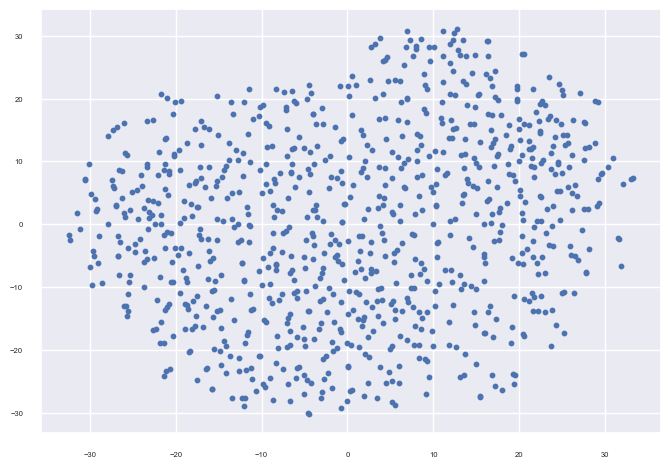

In [201]:
empl_with_prev_tsne_df = pd.DataFrame(TSNE(n_components=2, perplexity=35, random_state=4).fit_transform(get_pca_df(get_variance_thr_df(employed_with_prev_encoded, 0.18), 35)))

plt.scatter(empl_with_prev_tsne_df[0], empl_with_prev_tsne_df[1], s=10)

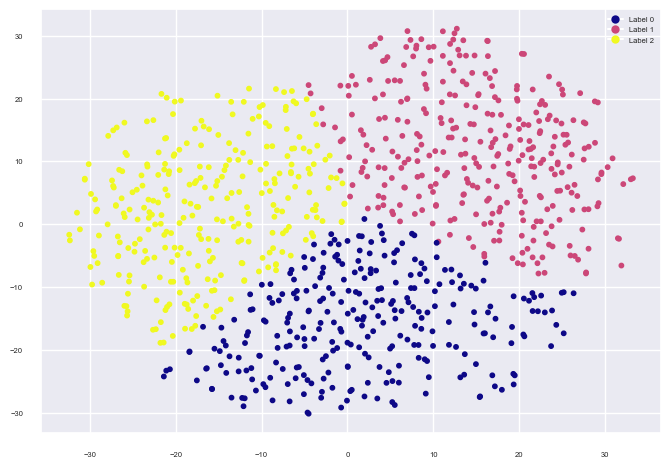

In [202]:
empl_with_prev_tsne_kmeans = KMeans(n_clusters=3, n_init='auto')
empl_with_prev_tsne_kmeans_labels = empl_with_prev_tsne_kmeans.fit_predict(empl_with_prev_tsne_df)

plot_cluster_result(empl_with_prev_tsne_df, empl_with_prev_tsne_kmeans_labels)

In [203]:
show_clustering_scores(empl_with_prev_tsne_df, empl_with_prev_tsne_kmeans_labels)

Silhouette: 0.4109290838241577. Higher is better.
Calinski-Harabasz: 839.8853067518469. Higher is better.
Davies-Bouldin: 0.854340412186548. Lower is better.


In [204]:
employed_with_prev['tsne_label'] =empl_with_prev_tsne_kmeans_labels

In [205]:
employed_with_prev.head(1)

,employee_count_bracket,empl_provides_mh_cov,empl_discussed_mh,empl_offers_mh_rsrcs,if_askfor_mh_medical_leave_how_easy,prev_empl_provided_mh_benefits,prev_empl_discussed_mh,prev_empl_provided_mh_rsrc,prev_empl_takes_mh_asseriously_as_ph,prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace,believes_beingident_as_mh_wouldhurt_career,thinks_coworkers_wouldviewthem_neg_if_mh,howwilling_share_mh_with_friendsfamily,observed_badly_handled_response_to_mh_inworkplace,has_family_history_mh,HAS_MH,sought_treatment,mh_interferes_w/work_ineffective_trt,age,sex,country_worksin,is_remote_working,has_tech_role,comfy_discussing_mh_with_ppl_atwork,prev_comfy_discussing_mh_with_ppl_atwork,morelikely_neg_conseq_for_mh_comparedto_ph,prev_morelikely_neg_conseq_for_mh_comparedto_ph,morelikely_tobringup_ph_over_mh_interview,tsne_label
0,26-500,Not eligible for coverage / N/A,No,No,Easy,"No, none did",I don't know,None did,I don't know,None of them,Maybe,"No, I don't think they would",Open,No,No,No,No,Not applicable to me,39,MALE,United Kingdom,Sometimes,Yes,Maybe,Some or all of my previous employers,No,Yes,No,1


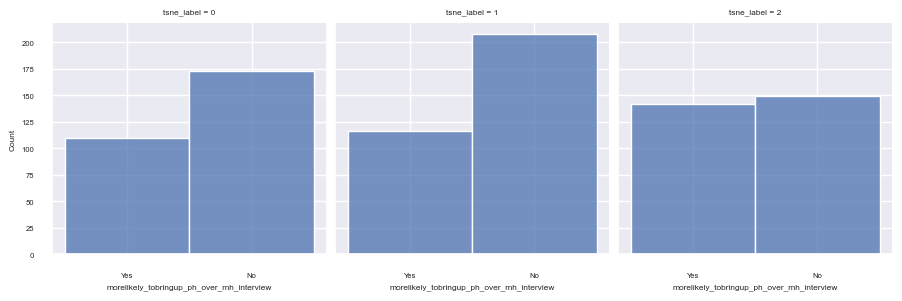

In [206]:
tsne_withprev_grid = sns.FacetGrid(employed_with_prev, col = 'tsne_label')
tsne_withprev_grid.map(sns.histplot, 'morelikely_tobringup_ph_over_mh_interview')

In [207]:
employed_with_prev_varselected = get_variance_thr_df(employed_with_prev_encoded, 0.2)
employed_with_prev_varselected_pca_df = get_pca_df(employed_with_prev_varselected, 15)

0.7234709748740447


In [208]:
get_correlated_features(employed_with_prev_varselected, 0.7)


[('encoder__believes_beingident_as_mh_wouldhurt_career_Maybe',
  'encoder__believes_beingident_as_mh_wouldhurt_career_Yes, I think it would'),
 ('encoder__HAS_MH_No',
  'encoder__mh_interferes_w/work_ineffective_trt_Not applicable to me'),
 ('encoder__prev_comfy_discussing_mh_with_ppl_atwork_No, at none of my previous employers',
  'encoder__prev_comfy_discussing_mh_with_ppl_atwork_Some or all of my previous employers')]

In [209]:
agg_labels = AgglomerativeClustering(n_clusters=4).fit_predict(employed_with_prev_varselected_pca_df)

show_clustering_scores(employed_with_prev_varselected_pca_df, agg_labels)

Silhouette: 0.07117055039494342. Higher is better.
Calinski-Harabasz: 69.25788635181665. Higher is better.
Davies-Bouldin: 2.634489275104783. Lower is better.


In [210]:
#kmeans_with_prev_labels = KMeans(n_clusters=3, n_init='auto').fit_predict(employed_with_prev_varselected_pca_df)
kmeans_with_prev_labels = KMeans(n_clusters=3, n_init='auto').fit_predict(get_pca_df(get_variance_thr_df(employed_with_prev_encoded, 0.15), 38))
show_clustering_scores(employed_with_prev_varselected_pca_df, kmeans_with_prev_labels)

0.9691011215956186
Silhouette: 0.0943302446722809. Higher is better.
Calinski-Harabasz: 90.63427226757929. Higher is better.
Davies-Bouldin: 2.6928678935463526. Lower is better.


In [211]:
gmm =  GaussianMixture(n_components=3, covariance_type='tied')

forgmm_df = get_pca_df(get_variance_thr_df(employed_with_prev_encoded, 0.15), 38)

gmm_labels = gmm.fit_predict(forgmm_df)
show_clustering_scores(forgmm_df, gmm_labels)

gmm.bic(forgmm_df)

0.9691011216527212
Silhouette: 0.04202576275124036. Higher is better.
Calinski-Harabasz: 41.57107333442085. Higher is better.
Davies-Bouldin: 3.9752959551801745. Lower is better.


55940.870301918454

In [212]:
employed_with_prev['gmm_label'] = gmm_labels
employed_with_prev['kmeans_label'] = kmeans_with_prev_labels

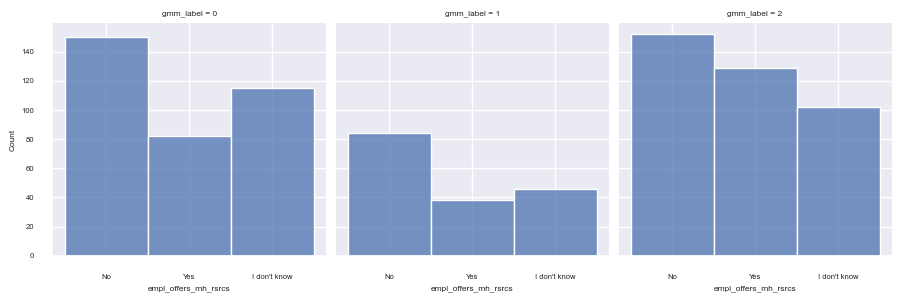

In [213]:
gmm_label_grp = employed_with_prev.groupby('gmm_label')

gmm_withprev_grid = sns.FacetGrid(employed_with_prev, col = 'gmm_label')
gmm_withprev_grid.map(sns.histplot, 'empl_offers_mh_rsrcs')

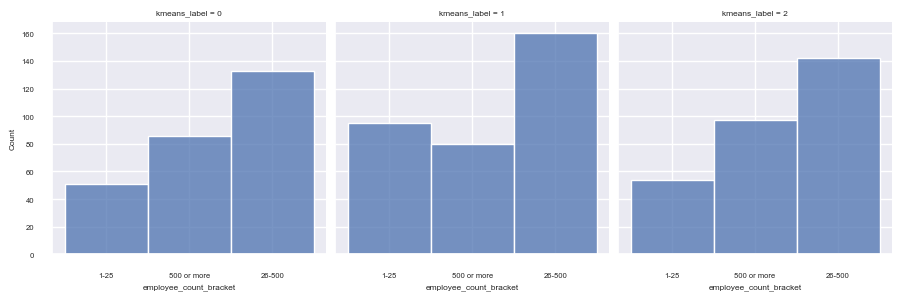

In [214]:
kmeans_with_prev_grid = sns.FacetGrid(employed_with_prev, col='kmeans_label')
kmeans_with_prev_grid.map(sns.histplot, 'employee_count_bracket')

In [215]:
#choosing also only the self-employed respondents with prev employers - leaving out only 27
self_employed = self_employed.loc[self_employed['has_prev_employers'] == 'Yes'].copy()
self_employed.drop('has_prev_employers', axis='columns', inplace=True)

In [216]:
#encoding the self-employed dataset and scaling the age column
self_employed_categorical = self_employed.drop('age', axis='columns')
self_employed_encoded = ohe_encode(self_employed, self_employed_categorical)
scale_age(self_employed_encoded)

0.9918779853644871


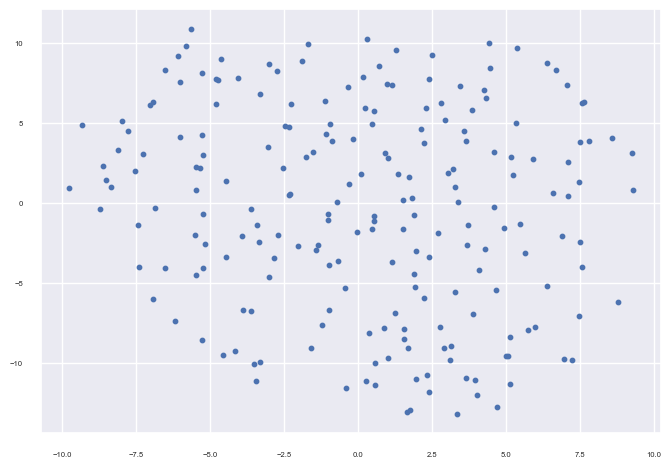

In [217]:
self_employed_pca_df = get_pca_df(self_employed_encoded, 35)
self_employed_tsne_df = pd.DataFrame(TSNE(n_components=2, perplexity=35, random_state=0).fit_transform(self_employed_pca_df))

plt.scatter(self_employed_tsne_df[0], self_employed_tsne_df[1], s=10)

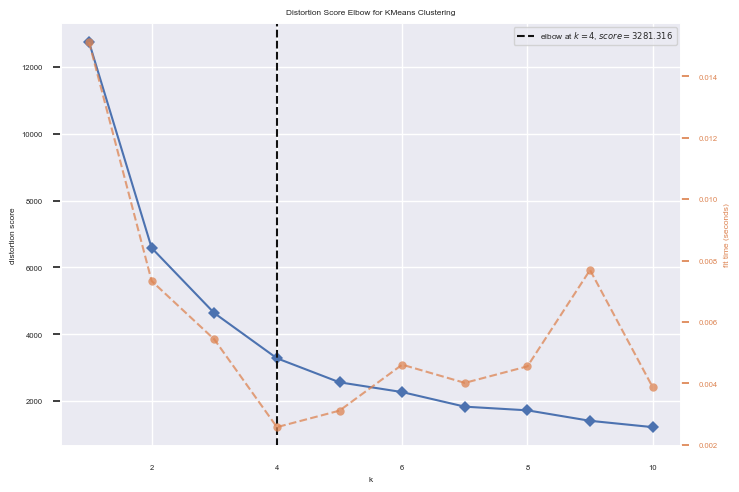

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [218]:
vis = KElbowVisualizer(KMeans(n_init='auto'), k=(1,11))
vis.fit(self_employed_tsne_df)
vis.show()

In [219]:
self_empl_kmeans_labels = KMeans(n_clusters=3, n_init='auto').fit_predict(self_employed_tsne_df)
show_clustering_scores(self_employed_tsne_df, self_empl_kmeans_labels)

Silhouette: 0.38900208473205566. Higher is better.
Calinski-Harabasz: 192.0164617619431. Higher is better.
Davies-Bouldin: 0.9251820755756599. Lower is better.


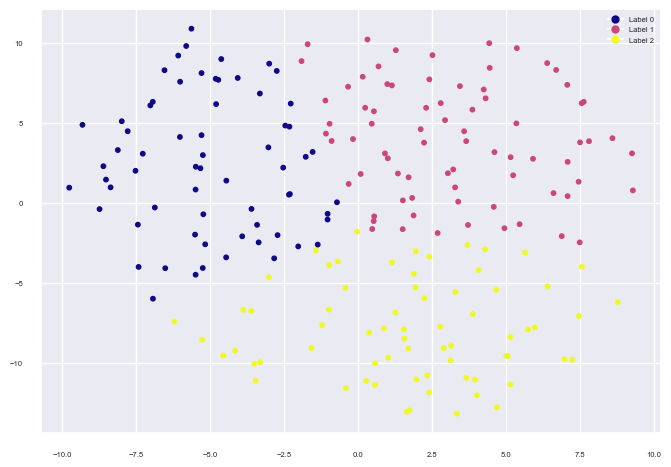

In [220]:
plot_cluster_result(self_employed_tsne_df, self_empl_kmeans_labels)

In [221]:
self_employed['kmeans_label'] = self_empl_kmeans_labels

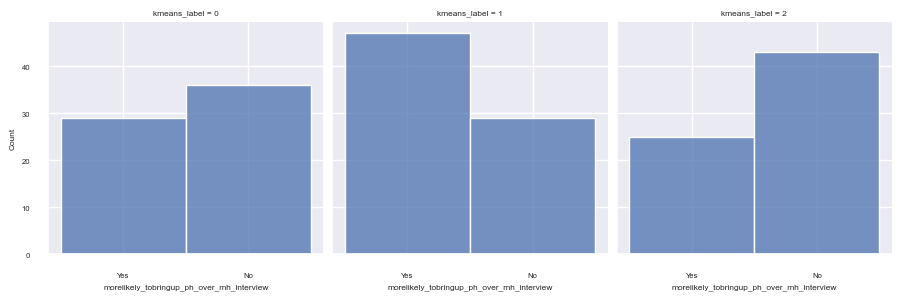

In [222]:
self_employed_grid = sns.FacetGrid(self_employed, col = 'kmeans_label')
self_employed_grid.map(sns.histplot, 'morelikely_tobringup_ph_over_mh_interview')